In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annearing_with_warmup.py
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, 2, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channel)
        self.relu  = nn.ReLU(inplace=False)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        return x
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = BasicBlock(1, 32)
        self.block2 = BasicBlock(32, 64)
        self.block3 = BasicBlock(64, 128)
        self.block4 = BasicBlock(128, 256)
        
        self.fc = nn.Linear(1024, 10, bias=False)
        
    def forward(self, x, aux_output=False):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x41 = x4.view(x4.size(0), -1)
        x5 = self.fc(x41)
        if aux_output:
            return x1, x2, x3, x4, x5
        else:
            return x5


In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('~/results/mnist', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('~/results/mnist', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=512, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000, shuffle=False, num_workers=4)

In [6]:
device = 'cuda'
net = Net().to(device)
optimizer = optim.Adadelta(net.parameters(), lr=1.0)

for epoch in range(3):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.436060
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.056454

Test set: Average loss: 0.2878, Accuracy: 9194/10000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.229066
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.069601

Test set: Average loss: 0.2002, Accuracy: 9438/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.125974
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020527

Test set: Average loss: 0.0790, Accuracy: 9763/10000 (98%)



In [7]:
class InvBasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, first_layer=False, output_padding=1):
        super(InvBasicBlock, self).__init__()
        
        self.first_layer = first_layer
        
        # self.relu  = nn.ReLU(inplace=False)
        self.bn1 = nn.BatchNorm2d(in_channel)
        self.conv1 = nn.ConvTranspose2d(in_channel, out_channel, 3, 2, 1, bias=False, output_padding=output_padding)
        
        
        # self.conv1 = nn.ConvTranspose2d(in_channel, out_channel, 3, 2, 1, bias=False, output_padding=1)
        # self.bn1   = nn.BatchNorm2d(out_channel)
        # self.relu1 = nn.LeakyReLU(inplace=False, negative_slope=0.2)
        # self.conv2 = nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False)
        #self.bn2   = nn.BatchNorm2d(out_channel)
        #self.relu2 = nn.LeakyReLU(inplace=False, negative_slope=0.2)

    def forward(self, x):
        # x = self.relu(x)
        x = self.bn1(x)
        x = self.conv1(x)
        
        
        # x = self.bn1(x)
        # x = self.relu(x)
        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.relu1(x)
        # x = self.conv2(x)

        return x
    
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.block1 = BasicBlock(1, 32)
#         self.block2 = BasicBlock(32, 64)
#         self.block3 = BasicBlock(64, 128)
#         self.block4 = BasicBlock(128, 256)
        
#         self.fc = nn.Linear(1024, 10, bias=False)
        
#     def forward(self, x, aux_output=False):
#         x1 = self.block1(x)
#         x2 = self.block2(x1)
#         x3 = self.block3(x2)
#         x4 = self.block4(x3)
#         x41 = x4.view(x4.size(0), -1)
#         x5 = self.fc(x41)
#         if aux_output:
#             return x1, x2, x3, x4, x5
#         else:
#             return x5

class InvNet(nn.Module):
    def __init__(self):
        super(InvNet, self).__init__()
        self.block1 = InvBasicBlock(32, 1, True)
        self.block2 = InvBasicBlock(64, 32)
        self.block3 = InvBasicBlock(128, 64, output_padding=0)
        self.block4 = InvBasicBlock(256, 128)
        self.fc = nn.Linear(10, 1024, bias=False)
        
    def forward(self, x5, aux_output=False):
        x41= self.fc(x5)
        x4 = x41.view(x41.size(0), 256, 2, 2)
        x3 = self.block4(x4)
        x2 = self.block3(x3)
        x1 = self.block2(x2)
        x  = self.block1(x1)
        if aux_output:
            return x, (x1, x2, x3, x4, x5)
        else:
            return x

In [8]:
def sample_from_dist(mean, std, res, sample_bsz=50):
    assert res.size(0)%sample_bsz==0
    for i in range(res.size(1)):
        # print(mean[i])
        # for j in range(res.size(0)//sample_bsz):
        #     res[j*sample_bsz:(j+1)*sample_bsz, i, :, :].normal_(mean[i].item(), std[i].item())
        res[:, i, :, :].normal_(mean[i].item(), std[i].item())
        
    return res

# sample_from_dist(torch.tensor([1.,2.,3.]), torch.tensor([1.,1.,1.]), [1,3,4,4])

In [9]:
inv_net = InvNet().cuda()

inv_net.block1.conv1.weight.data = net.block1.conv1.weight.data /4.
inv_net.block1.bn1.weight.data = torch.sqrt(net.block1.bn1.running_var.data)
inv_net.block1.bn1.bias.data = net.block1.bn1.running_mean.data

inv_net.block2.conv1.weight.data = net.block2.conv1.weight.data /2.
inv_net.block2.bn1.weight.data = torch.sqrt(net.block2.bn1.running_var.data)
inv_net.block2.bn1.bias.data = net.block2.bn1.running_mean.data

inv_net.block3.conv1.weight.data = net.block3.conv1.weight.data /0.7
inv_net.block3.bn1.weight.data = torch.sqrt(net.block3.bn1.running_var.data)
inv_net.block3.bn1.bias.data = net.block3.bn1.running_mean.data

inv_net.block4.conv1.weight.data = net.block4.conv1.weight.data /0.5
inv_net.block4.bn1.weight.data = torch.sqrt(net.block4.bn1.running_var.data)
inv_net.block4.bn1.bias.data = net.block4.bn1.running_mean.data


# inv_net.fc.weight.data = net.fc.weight.data.T / 1.5
inv_net.fc.weight.data = torch.pinverse(net.fc.weight.data)

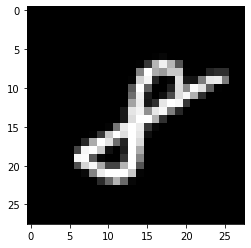

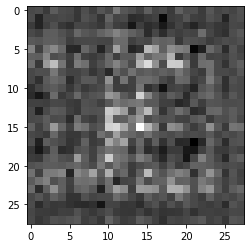

In [10]:
inv_net.train()
net.eval()

data, _ = next(iter(train_loader))
data = data.cuda()

inv_data = inv_net(net(data))

image_idx = 1
plt.imshow(data[image_idx][0].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(inv_data[image_idx][0].detach().cpu().numpy(), cmap='gray')
plt.show()

In [11]:
class DeepInversionFeatureHook():
    '''
    Implementation of the forward hook to track feature statistics and compute a loss on them.
    Will compute mean and variance, and will use l2 as a loss
    '''

    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # hook co compute deepinversion's feature distribution regularization
        nch = input[0].shape[1]

        mean = input[0].mean([0, 2, 3])
        var = input[0].permute(1, 0, 2, 3).contiguous().view([nch, -1]).var(1, unbiased=False)

        # forcing mean and variance to match between two distributions
        # other ways might work better, e.g. KL divergence
        r_feature = torch.norm(module.running_var.data.type(var.type()) - var, 2) + torch.norm(
            module.running_mean.data.type(var.type()) - mean, 2)

        self.r_feature = r_feature
        # must have no output

    def close(self):
        self.hook.remove()
        
        
loss_r_feature_layers = []
for module in net.modules():
    if isinstance(module, nn.BatchNorm2d):
        loss_r_feature_layers.append(DeepInversionFeatureHook(module))

In [12]:
inv_optimizer = optim.Adam(inv_net.parameters(), lr=0.001, betas=(0.5, 0.999))
# block1_optimizer = optim.SGD(inv_block1.parameters(), lr=0.01, momentum=0.8)
# block1_optimizer = optim.Adadelta(inv_block1.parameters(), lr=1.0)
scheduler = optim.lr_scheduler.CosineAnnealingLR(inv_optimizer, T_max=100)
# block1_optimizer = optim.ASGD(inv_block1.parameters())
# block1_optimizer = optim.LBFGS(inv_block1.parameters(), lr=1.)
# scheduler = CosineAnnealingWarmUpRestarts(block1_optimizer, T_0=500, T_mult=1, eta_max=0.0002, T_up=50)


net.eval()
inv_net.train()

losses = []



for epoch in range(100):
    for batch_idx, (image, target) in enumerate(train_loader):
        image = image.cuda()
        inv_net.zero_grad()
        net.zero_grad()
        with torch.no_grad():
            output = net(image, False)
            
        inv_image, (inv_o1, inv_o2, inv_o3, inv_o4, inv_o5)  = inv_net(output.detach(), True)
        from_inv_o1, from_inv_o2, from_inv_o3, from_inv_o4, from_inv_o5 = net(inv_image, True)
        
        loss_distr = sum([mod.r_feature for mod in loss_r_feature_layers])
        assert inv_o1.size()==from_inv_o1.size()
        assert inv_o2.size()==from_inv_o2.size()
        assert inv_o3.size()==from_inv_o3.size()
        assert inv_o4.size()==from_inv_o4.size()
        assert inv_o5.size()==from_inv_o5.size()
        
        loss_c = F.mse_loss(inv_o1, from_inv_o1)*10 + \
                 F.mse_loss(inv_o2, from_inv_o2) + \
                 F.mse_loss(inv_o3, from_inv_o3) + \
                 F.mse_loss(inv_o4, from_inv_o4) + \
                 F.mse_loss(inv_o5, from_inv_o5)
        loss = loss_c*10. #+ loss_distr
        
        
        loss.backward()
        inv_optimizer.step()
        scheduler.step()

        if batch_idx%200==0:
            # loss = closure()
            print('loss_c:', loss_c.item())
            print('loss_distr:', loss_distr.item())
            print('loss:', loss.item())
            print('----------- \n')
            losses.append(loss.item())

loss_c: 19.245546340942383
loss_distr: 17.604516983032227
loss: 210.0599822998047
----------- 

loss_c: 1.618457555770874
loss_distr: 10.831052780151367
loss: 27.015628814697266
----------- 

loss_c: 1.2506364583969116
loss_distr: 9.175178527832031
loss: 21.681543350219727
----------- 

loss_c: 2.3275232315063477
loss_distr: 8.816190719604492
loss: 32.09142303466797
----------- 

loss_c: 0.8089758157730103
loss_distr: 7.159543514251709
loss: 15.24930191040039
----------- 

loss_c: 1.151085615158081
loss_distr: 7.086663246154785
loss: 18.597518920898438
----------- 

loss_c: 0.6988974213600159
loss_distr: 6.2618560791015625
loss: 13.250829696655273
----------- 

loss_c: 0.7507450580596924
loss_distr: 6.033897399902344
loss: 13.54134750366211
----------- 

loss_c: 1.0096689462661743
loss_distr: 5.793343544006348
loss: 15.890032768249512
----------- 

loss_c: 0.6462948322296143
loss_distr: 5.611202716827393
loss: 12.074151039123535
----------- 

loss_c: 1.3574254512786865
loss_distr: 6.00

KeyboardInterrupt: 

In [13]:
inv_net.eval()
net.eval()

data, _ = next(iter(train_loader))
data = data.cuda()

inv_data = inv_net(net(data))



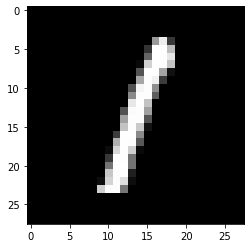

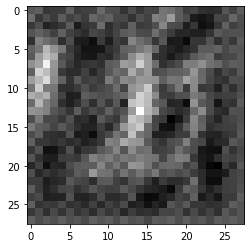

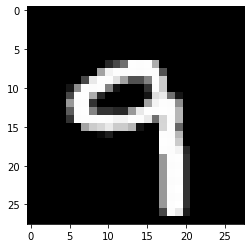

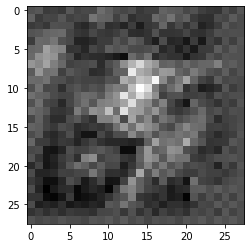

In [14]:
image_idx = 9
plt.imshow(data[image_idx][0].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(inv_data[image_idx][0].detach().cpu().numpy(), cmap='gray')
plt.show()

image_idx = 1
plt.imshow(data[image_idx][0].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(inv_data[image_idx][0].detach().cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
assert 1==0

In [ ]:
import collections

block1_optimizer.zero_grad()
optimizer.zero_grad()

optimizer.state = collections.defaultdict(dict)
block1_optimizer.state = collections.defaultdict(dict)

del random_input
torch.cuda.empty_cache()

In [ ]:
inv_block2 = InvBasicBlock(64,32).to(device)
block2_optimizer = optim.Adam([inv_block2.conv1.weight, inv_block1.conv1.weight], lr=0.0002, betas=(0.5, 0.999))


inv_block2.conv1.weight.data = net.block2.conv1.weight.data

inv_block2.bn1.weight.data = torch.sqrt(net.block2.bn1.running_var.data)
inv_block2.bn1.bias.data = net.block2.bn1.running_mean.data
# block1_optimizer = optim.SGD(inv_block1.parameters(), lr=0.01, momentum=0.8)
# block1_optimizer = optim.Adadelta(inv_block1.parameters(), lr=1.0)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(block1_optimizer, T_max=10000)
# block1_optimizer = optim.ASGD(inv_block1.parameters())
# block1_optimizer = optim.LBFGS(inv_block1.parameters(), lr=1.)
# scheduler = CosineAnnealingWarmUpRestarts(block1_optimizer, T_0=500, T_mult=1, eta_max=0.0002, T_up=50)


net.eval()
inv_block2.train()

losses = []


random_input = torch.empty([10000, 64, 7, 7], device='cuda')

for batch_idx in range(5000):
    inv_block2.zero_grad()
    inv_block1.zero_grad()
    net.zero_grad()

    block_output = F.relu(sample_from_dist(net.block2.bn1.bias, 
                                       net.block2.bn1.weight, 
                                       random_input), inplace=True)
    inv_block_input = inv_block1(inv_block2(block_output))
    inv_block_output = net.block2(net.block1(inv_block_input))
    assert inv_block_output.size()==block_output.size()
    loss = F.mse_loss(inv_block_output, block_output)
    loss.backward()
    block2_optimizer.step()
    # scheduler.step()
    
    
    # def closure():
    #     block1_optimizer.zero_grad()
    #     optimizer.zero_grad()

    #     block_output = F.relu(sample_from_dist(net.block1.bn1.bias, 
    #                                        net.block1.bn1.weight, 
    #                                        [256, 32, 14, 14]))
    #     inv_block_output = net.block1(inv_block1(block_output))
    #     loss = F.mse_loss(inv_block_output, block_output)
    #     loss.backward()
    #     return loss

    # block1_optimizer.step(closure)
    
    if batch_idx%200==0:
        # loss = closure()
        print(loss.item())
        losses.append(loss.item())
        
    del inv_block_output, block_output
    torch.cuda.empty_cache()

In [ ]:
rand_inv_block1 = InvBasicBlock(32,1).to(device)
rand_inv_block2 = InvBasicBlock(64,32).to(device)

rand_inv_block2.eval()
inv_block2.eval()

with torch.no_grad():
    for image, target in train_loader:
        image = image.cuda()
        out_block2 = net.block2(net.block1(image))
        inv_image = inv_block1(inv_block2(out_block2)).detach()
        rand_inv_image = rand_inv_block1(rand_inv_block2(out_block2)).detach()
    
image_idx = 1

plt.imshow(image[image_idx][0].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(inv_image[image_idx][0].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(rand_inv_image[image_idx][0].cpu().numpy(), cmap='gray')
plt.show()